# Profiling and Analysis Questions

- Do users purchase different products at different time of day?
- What clusters of aisle purchase standout?
- Do users who reorder have different behaviour? 
- does the behaviour change per number of order (eg.: min vs median, etc)
- do users purchase differently depending on days or weeks since last purchase?
- do users purchase differently on the weekends vs weekday?
- What is the top product/aisle purchased first or last per order?
- Reordered is per product. what products are most reordered by users?
- how many orders per user_id? 

## Aggregations
- days/weeks since last order
- number of orders (better to consider order number instead of count of order_id due to incomplete customer history)
- number of users who reordered
- orders per time of day (numeric or discrete count)


# File and libraries

In [43]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart Market Basket"


## DSLabs

In [44]:
%run "scripts/dslabs_functions.py"

# data functions

In [45]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [46]:
test_data=True
# test_data=False

if test_data==True:

    data=pd.read_csv(filepath)

    # 5% sample
    data=data.sample(frac=0.05, replace=False)

    # sampled data to use in heavy analysis scripts like sparsity
    sampled_data=data.sample(frac=0.25, replace=False)


else:
    data=pd.read_csv(filepath)
    
    # sampled data to use in heavy analysis scripts like sparsity
    sampled_data=data.sample(frac=0.01, replace=False)



data=enrich_instacart_df(data)


id_cols=['order_id', 'product_id', 'user_id','aisle_id','department_id']
# data=data.drop(columns=id_cols, axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16255 entries, 0 to 16254
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 16255 non-null  int64  
 1   product_id               16255 non-null  int64  
 2   add_to_cart_order        16255 non-null  int64  
 3   reordered                16255 non-null  int64  
 4   user_id                  16255 non-null  int64  
 5   order_number             16255 non-null  int64  
 6   order_dow                16255 non-null  int64  
 7   order_hour_of_day        16255 non-null  int64  
 8   days_since_prior_order   15214 non-null  float64
 9   order_time_of_day        16255 non-null  object 
 10  is_weekend               16255 non-null  int64  
 11  weeks_since_prior_order  15214 non-null  float64
 12  product_name             16255 non-null  object 
 13  aisle_id                 16255 non-null  int64  
 14  department_id         

# Dimensionality

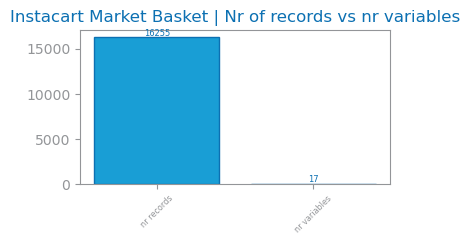

In [47]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

figure(figsize=(4, 2))
values: dict[str, int] = {"nr records": data.shape[0], "nr variables": data.shape[1]}
plot_bar_chart(
    list(values.keys()), list(values.values()), title=f"{file_tag} | Nr of records vs nr variables"
)
# savefig(f"{file_tag}_records_variables.png")
show()

## Missing values

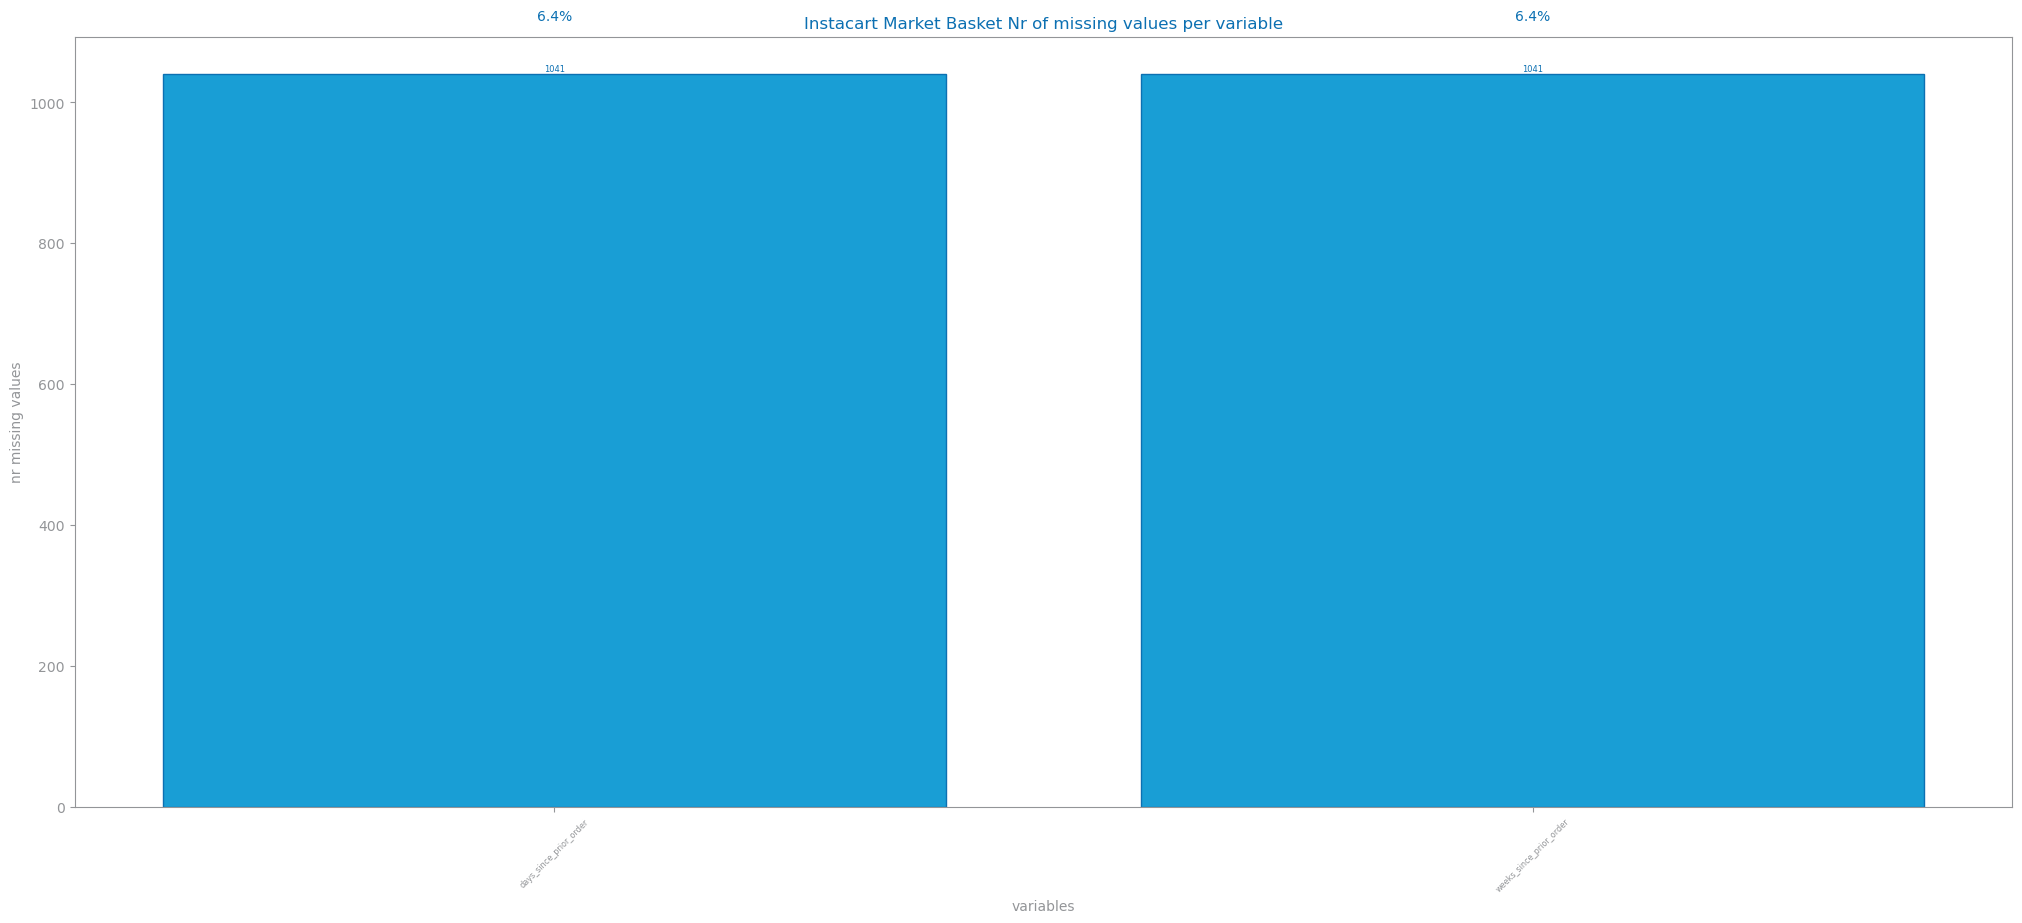

In [48]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

mv: dict[str, int] = {}
total_rows = len(data)

for var in data.columns:
    nr: int = data[var].isna().sum()
    if nr > 0:
        percentage = (nr / total_rows) * 100
        mv[var] = (nr, percentage)

sorted_mv = dict(sorted(mv.items(), key=lambda item: item[1][0], reverse=True))

variables = list(sorted_mv.keys())
missing_values = [val[0] for val in sorted_mv.values()]
percentages = [val[1] for val in sorted_mv.values()]

figure(figsize=(25, 10)) #(largura,altura) 

plot_bar_chart(
    variables,
    missing_values,
    title=f"{file_tag} Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
for i, (var, perc) in enumerate(zip(variables, percentages)):
    text(i, missing_values[i] + max(missing_values) * 0.08, f"{perc:.1f}%", ha="center", va="center_baseline")

savefig(f"images/{file_tag}_mv.png")
show()

## Variables Type

In [49]:
data.dtypes


order_id                     int64
product_id                   int64
add_to_cart_order            int64
reordered                    int64
user_id                      int64
order_number                 int64
order_dow                    int64
order_hour_of_day            int64
days_since_prior_order     float64
order_time_of_day           object
is_weekend                   int64
weeks_since_prior_order    float64
product_name                object
aisle_id                     int64
department_id                int64
aisle                       object
department                  object
dtype: object

In [50]:
from pandas import Series, to_numeric, to_datetime


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)

{'numeric': ['add_to_cart_order', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'weeks_since_prior_order'], 'binary': ['reordered', 'is_weekend'], 'date': [], 'symbolic': ['order_time_of_day', 'product_name', 'aisle', 'department'], 'id': ['order_id', 'product_id', 'user_id', 'aisle_id', 'department_id']}


### variables per type plot

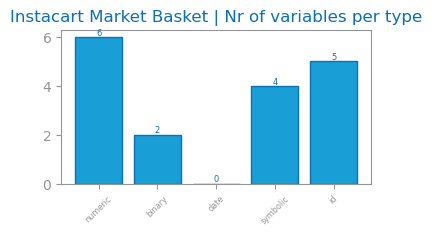

In [51]:
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title=f"{file_tag} | Nr of variables per type"
)
# savefig(f"{file_tag}_variable_types.png")
show()

# Data Distribution

## describe

In [52]:
summary5: DataFrame = data.describe(include="all")
summary5

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_time_of_day,is_weekend,weeks_since_prior_order,product_name,aisle_id,department_id,aisle,department
count,1.625500e+04,16255.000000,16255.000000,16255.000000,16255.000000,16255.000000,16255.000000,16255.000000,15214.000000,16255,16255.000000,15214.000000,16255,16255.000000,16255.000000,16255,16255
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,6208,NaN,NaN,133,21
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afternoon,NaN,NaN,Banana,NaN,NaN,fresh fruits,produce
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6493,NaN,NaN,207,NaN,NaN,1772,4728
mean,1.701449e+06,25606.421839,8.352815,0.584866,103614.484220,17.150846,2.709505,13.410028,11.112002,NaN,0.261212,1.558302,NaN,71.476715,9.955152,NaN,NaN
std,9.834628e+05,14095.142444,7.008580,0.492760,59452.953526,17.387880,2.080488,4.222058,8.806423,NaN,0.439309,1.230215,NaN,37.955179,6.267372,NaN,NaN
min,5.000000e+02,4.000000,1.000000,0.000000,11.000000,1.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,1.000000,1.000000,NaN,NaN
25%,8.489860e+05,13535.500000,3.000000,0.000000,51791.500000,5.000000,1.000000,10.000000,5.000000,NaN,0.000000,1.000000,NaN,31.000000,4.000000,NaN,NaN
50%,1.695369e+06,25647.000000,6.000000,1.000000,104049.000000,11.000000,2.000000,13.000000,8.000000,NaN,0.000000,1.000000,NaN,83.000000,9.000000,NaN,NaN
75%,2.551364e+06,37825.000000,11.000000,1.000000,155697.000000,24.000000,5.000000,16.000000,15.000000,NaN,1.000000,2.000000,NaN,107.000000,16.000000,NaN,NaN


## Numeric Variables

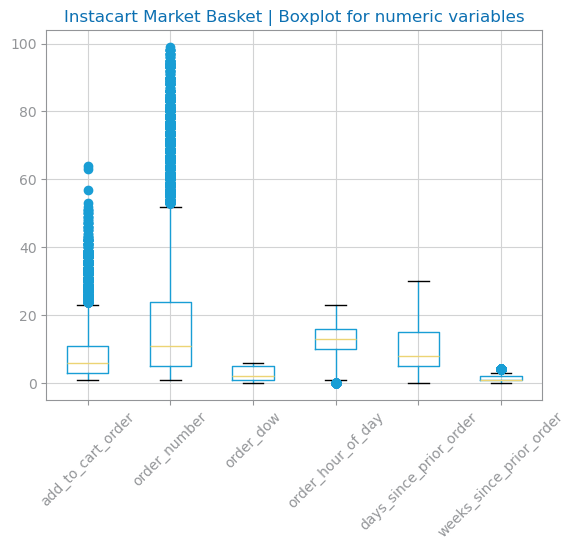

In [53]:
from matplotlib.pyplot import savefig, show, title


variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variable_types["numeric"]


if [] != numeric:
    data[numeric].boxplot(rot=45)
    title(f'{file_tag} | Boxplot for numeric variables')  # Correct way to set title
    savefig(f"images/{file_tag}_global_boxplot.png")
    show()
else:
    print("There are no numeric variables.")

## numeric variables distribution breakdown

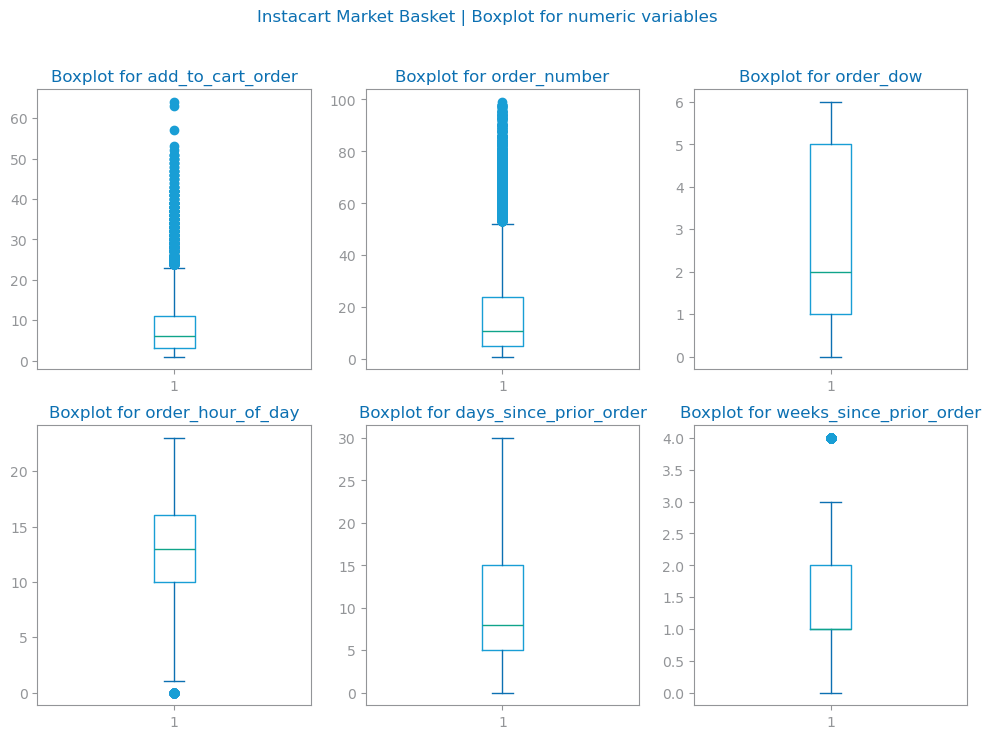

In [54]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric)):
        axs[i, j].set_title("Boxplot for %s" % numeric[n])
        axs[i, j].boxplot(data[numeric[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

## standard outliers for numeric variables

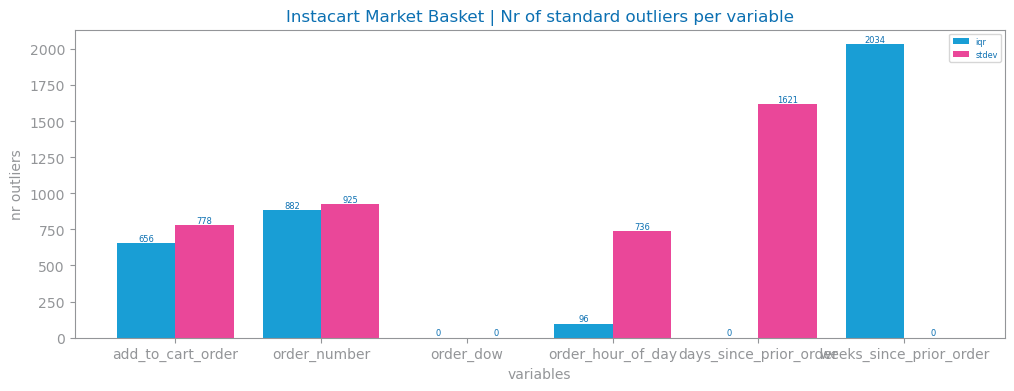

In [55]:
from pandas import Series
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_multibar_chart

NR_STDEV: int = 2
IQR_FACTOR: float = 1.5


def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    if std_based:
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom


def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        outliers_stdev += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        outliers_iqr += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}


if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric)
    figure(figsize=(12, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title=f"{file_tag} | Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"images/{file_tag}_outliers_standard.png")
    show()
else:
    print("There are no numeric variables.")

## outliers factorized

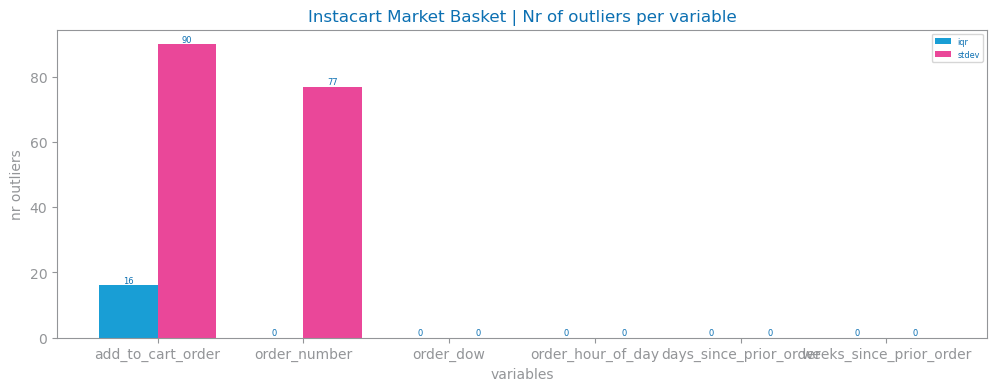

In [56]:
if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric, nrstdev=4, iqrfactor=4.5)
    figure(figsize=(12, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title=f"{file_tag} | Nr of outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"images/{file_tag}_outliers.png")
    show()
else:
    print("There are no numeric variables.")

## numeric histograms

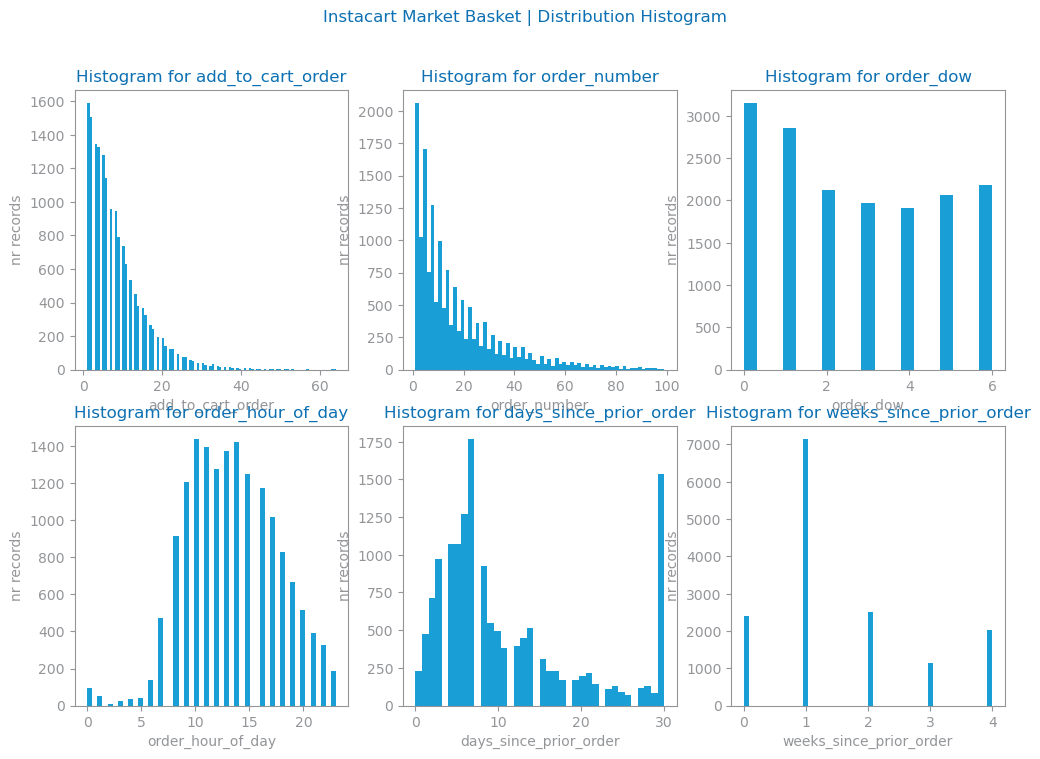

In [57]:
from dslabs_functions import set_chart_labels


if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i: int
    j: int
    i, j = 0, 0
    
    fig.suptitle(f'{file_tag} | Distribution Histogram')

    for n in range(len(numeric)):
        set_chart_labels(
            axs[i, j],
            title=f"Histogram for {numeric[n]}",
            xlabel=numeric[n],
            ylabel="nr records",
        )
        axs[i, j].hist(data[numeric[n]].dropna().values, "auto")
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_histograms_numeric.png")
    show()
else:
    print("There are no numeric variables.")

# Symbolic Variables

## count by order id, user_id

In [58]:
from IPython.display import display, HTML
import ipywidgets as widgets
from IPython.display import display

# List of columns to group by
groupby_cols = ['order_time_of_day', 'product_name', 'aisle', 'department', 'reordered', 'is_weekend', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'weeks_since_prior_order']

# count unique values of the id columns
count_cols=['order_id', 'user_id']

# Dictionary to store the resulting dataframes
grouped_dataframes = {}

# Loop through the list of columns and perform groupby and aggregation
for col in groupby_cols:
    grouped_df = data.groupby(col)[count_cols].nunique().sort_values(by=count_cols[0], ascending=False)
    
    # Calculate the percentage share for each count column
    for count_col in count_cols:
        grouped_df[f'{count_col}_share'] = (grouped_df[count_col] / grouped_df[count_col].sum() * 100).round(2)
    
    grouped_dataframes[col] = grouped_df

# Display the resulting dataframes as HTML tables
for col, df in grouped_dataframes.items():
    display(HTML(f"<h3>Group by {col}</h3>"))
    display(df)

,order_id,user_id,order_id_share,user_id_share
order_time_of_day,,,,
Afternoon,4725,4587,40.09,40.02
Morning,3995,3857,33.90,33.65
Evening,2528,2487,21.45,21.70
Night,537,531,4.56,4.63


,order_id,user_id,order_id_share,user_id_share
product_name,,,,
Banana,207,205,1.27,1.26
Bag of Organic Bananas,164,163,1.01,1.00
Organic Strawberries,127,126,0.78,0.78
Organic Baby Spinach,119,119,0.73,0.73
Organic Hass Avocado,107,107,0.66,0.66
...,...,...,...,...
Dairy Pure Whole Milk,1,1,0.01,0.01
Dairy Milk Fruit & Nut Chocolate Bar,1,1,0.01,0.01
Dairy Free Vegetable Pot Pie,1,1,0.01,0.01


,order_id,user_id,order_id_share,user_id_share
aisle,,,,
fresh fruits,1684,1659,10.64,10.56
fresh vegetables,1610,1582,10.17,10.07
packaged vegetables fruits,872,864,5.51,5.50
yogurt,632,625,3.99,3.98
packaged cheese,462,456,2.92,2.90
...,...,...,...,...
beauty,3,3,0.02,0.02
first aid,3,3,0.02,0.02
baby accessories,3,3,0.02,0.02


,order_id,user_id,order_id_share,user_id_share
department,,,,
produce,4125,3987,27.24,26.81
dairy eggs,2524,2469,16.67,16.60
snacks,1339,1316,8.84,8.85
beverages,1270,1249,8.39,8.40
frozen,1032,1024,6.81,6.89
pantry,941,933,6.21,6.27
bakery,585,582,3.86,3.91
deli,532,528,3.51,3.55
canned goods,462,461,3.05,3.10


,order_id,user_id,order_id_share,user_id_share
reordered,,,,
1,7486,7031,57.28,56.33
0,5583,5450,42.72,43.67


,order_id,user_id,order_id_share,user_id_share
is_weekend,,,,
0,8715,8267,73.95,73.37
1,3070,3000,26.05,26.63


,order_id,user_id,order_id_share,user_id_share
order_number,,,,
1,757,757,6.42,6.42
2,746,746,6.33,6.33
3,740,740,6.28,6.28
4,655,655,5.56,5.56
5,568,568,4.82,4.82
...,...,...,...,...
97,4,4,0.03,0.03
87,3,3,0.03,0.03
96,3,3,0.03,0.03


,order_id,user_id,order_id_share,user_id_share
order_dow,,,,
0,2224,2183,18.87,18.82
1,2051,2008,17.40,17.31
2,1563,1534,13.26,13.22
6,1560,1541,13.24,13.28
5,1510,1493,12.81,12.87
3,1473,1454,12.50,12.53
4,1404,1389,11.91,11.97


,order_id,user_id,order_id_share,user_id_share
order_hour_of_day,,,,
14,1029,1025,8.73,8.76
10,1000,990,8.49,8.46
11,992,985,8.42,8.42
13,987,980,8.38,8.38
12,916,909,7.77,7.77
15,911,905,7.73,7.74
9,888,880,7.54,7.52
16,882,875,7.48,7.48
17,750,746,6.36,6.38


,order_id,user_id,order_id_share,user_id_share
days_since_prior_order,,,,
7.0,1242,1224,11.26,11.20
30.0,1119,1118,10.15,10.23
6.0,874,865,7.93,7.91
4.0,810,792,7.34,7.25
5.0,788,775,7.15,7.09
3.0,731,716,6.63,6.55
8.0,668,663,6.06,6.07
2.0,581,571,5.27,5.22
1.0,384,380,3.48,3.48


,order_id,user_id,order_id_share,user_id_share
weeks_since_prior_order,,,,
1.0,5119,4886,46.42,45.74
0.0,1875,1786,17.00,16.72
2.0,1757,1741,15.93,16.30
4.0,1469,1463,13.32,13.69
3.0,808,807,7.33,7.55


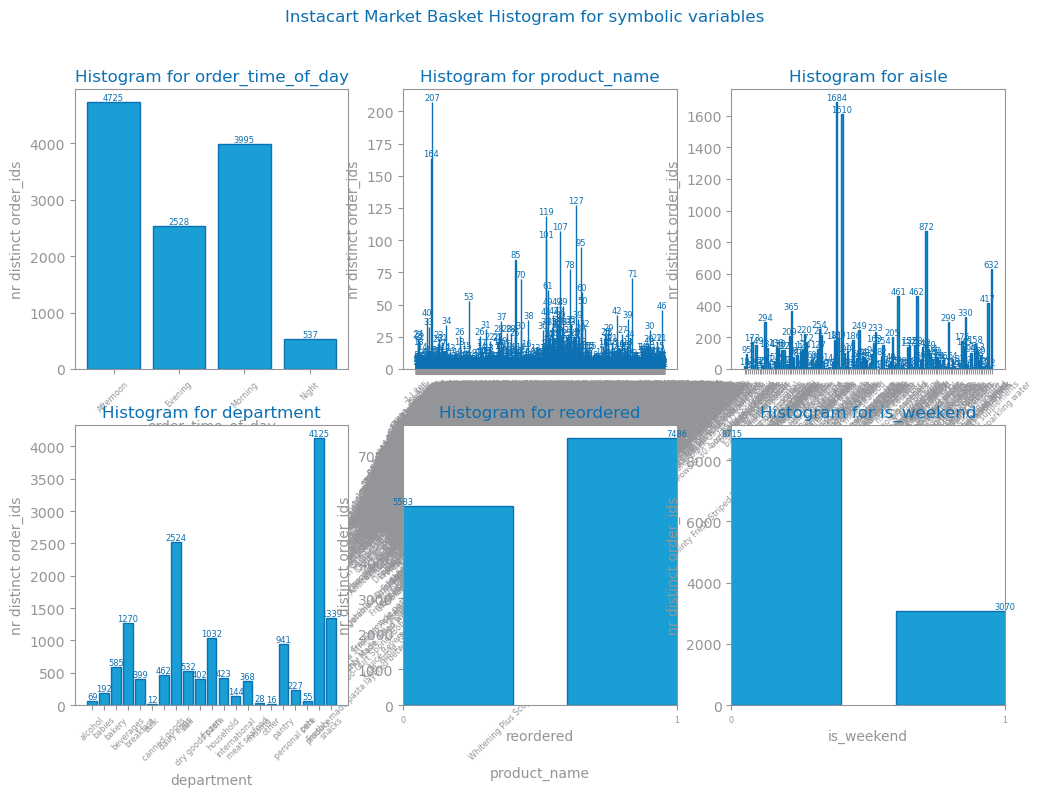

In [59]:
from dslabs_functions import plot_bar_chart

symbolic: list[str] = variable_types["symbolic"] + variable_types["binary"]
if [] != symbolic:
    rows, cols = define_grid(len(symbolic))
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0

    fig.suptitle(f'{file_tag} Histogram for symbolic variables')
    
    for n in range(len(symbolic)):
        counts: Series = data.groupby(symbolic[n])['order_id'].nunique()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[i, j],
            title=f"Histogram for %s" % symbolic[n],
            xlabel=symbolic[n],
            ylabel="nr distinct order_ids",
            percentage=False,
        )
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_histograms_symbolic.png")
    show()
else:
    print("There are no symbolic variables.")

# Correlation Analysis

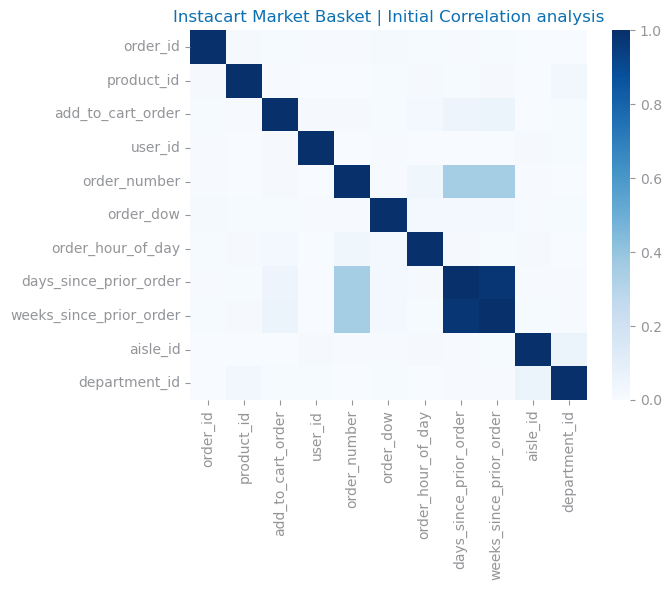

In [60]:
from seaborn import heatmap
from dslabs_functions import get_variable_types
from matplotlib.pyplot import figure, title, savefig, show

variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variables_types["numeric"]
corr_mtx: DataFrame = data[numeric].corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=numeric,
    yticklabels=numeric,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)

title(f'{file_tag} | Initial Correlation analysis')

savefig(f"images/{file_tag}_correlation_analysis.png")
show()